In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data

df = load_data.load_county_level()
df = df.sort_values('tot_deaths', ascending=False)
important_vars = load_data.important_keys(df)
print(df.keys())

Loading BokehJS ...

Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       '#Deaths_3/20/2020', '#Deaths_3/21/2020', '#Deaths_3/22/2020',
       '#Deaths_3/23/2020', '#Deaths_3/24/2020', '#Deaths_3/25/2020', 'deaths',
       'cases', 'tot_deaths', 'tot_cases'],
      dtype='object', length=7315)


## how many deaths/cases are there

In [2]:
df[['tot_deaths', 'tot_cases', 'StateName', 'CountyName', ]].head(10)

,tot_deaths,tot_cases,StateName,CountyName
908,280,0.0,New York,New York
1425,100,0.0,Washington,King
554,37,0.0,Louisiana,Orleans
670,21,0.0,Michigan,Wayne
925,20,0.0,New York,Suffolk
907,17,0.0,New York,Nassau
124,17,0.0,California,Santa Clara
1436,16,0.0,Washington,Snohomish
847,14,0.0,New Jersey,Bergen
103,13,0.0,California,Los Angeles


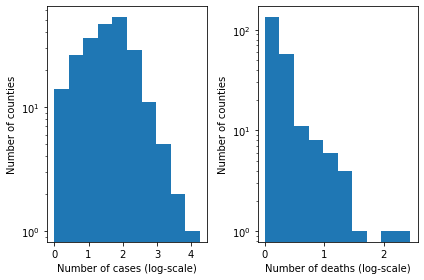

In [6]:
d = df[df['tot_deaths'] > 0]
R, C = 1, 2
plt.subplot(R, C, 1)
plt.hist(np.log10(d['tot_cases']))
plt.xlabel('Number of cases (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')

plt.subplot(R, C, 2)
plt.hist(np.log10(d['tot_deaths']))
plt.xlabel('Number of deaths (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')
plt.tight_layout()
plt.show()

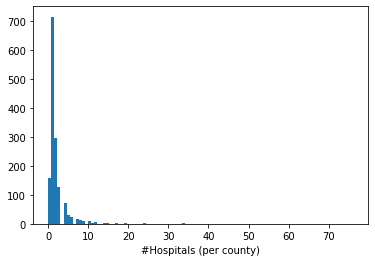

In [7]:
plt.hist(df['#Hospitals'], bins=100)
plt.xlabel('#Hospitals (per county)')
plt.show()

# correlations

In [ ]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = df[[k for k in important_vars if not 'PopMale' in k and not 'PopFmle' in k and not 'MortalityAge' in k and not 'PopTotal' in k] + 
        ['tot_deaths', 'tot_cases']]

# Compute the correlation matrix
corrs = d.corr(method='spearman')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(8, 8), dpi=300)
sns.heatmap(corrs, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig('results/correlations_heatmap.png')
plt.show()

In [ ]:
keys = np.array(corrs.index)
k = np.where(keys == 'tot_deaths')[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=300, figsize=(6, 5))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with # deaths')
plt.tight_layout()
plt.savefig('results/correlations.png')
plt.show()

# interactive plots

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz.plot_counties(d, 
                          variable_to_distribute='tot_cases',
                          variables_to_display=important_vars,
                          state=state,
                          logcolor=False)
    
    output_file(f"results/{state}.html", mode='inline')
    show(p)
    save(p)

In [ ]:
sorted(list([k for k in df.keys() if '' in k.lower()]))

## plot political leaning

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz.plot_counties(d, 
                          variable_to_distribute='dem_to_rep_ratio',
                          variables_to_display=important_vars,
                          state=state,
                          logcolor=False)
    show(p)